#### E01
##### Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

#### E01a

In [21]:
# import words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [22]:
# conversion table
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [23]:
import torch

In [24]:
# counting table
N = torch.zeros((27, 27, 27), dtype=torch.int32)

for word in words:
    chars = ['.', '.'] + list(word) + ['.']
    for char1, char2, char3 in zip(chars, chars[1:], chars[2:]):
        ix1 = stoi[char1]
        ix2 = stoi[char2]
        ix3 = stoi[char3]
        # print(char1, char2, char3)
        # print(ix1, ix2, ix3)
        N[ix1, ix2, ix3] += 1

print(N[0, 0])

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)


In [25]:
# probabilities
P = (N+1).float()
P /= P.sum(dim=2, keepdim=True)
P[0, 0].sum()

tensor(1.)

In [26]:
# generating names
g = torch.Generator().manual_seed(2147483647)
for _ in range(10):
    out = []
    ix1, ix2 = 0, 0
    while True:
        probs = P[ix1, ix2]
        ix1 = ix2
        ix2 = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
        out.append(itos[ix2])
        if ix2 == 0:
            break
    print(''.join(out))

miq.
axx.
mereyannyaar.
knooraen.
el.
marviovania.
odarimalabelon.
hamirelslen.
elyn.
rae.


In [27]:
log_likelihood = 0.0
n = 0

for word in words:
    chars = ['.', '.'] + list(word) + ['.']
    for char1, char2, char3 in zip(chars, chars[1:], chars[2:]):
        probs = P[stoi[char1], stoi[char2], stoi[char3]]
        log_likelihood += torch.log(probs)
        n += 1

print(f'{log_likelihood=}')
neg_log_likelihood = -log_likelihood
print(f'{neg_log_likelihood=}')
print(f'avg neg log likelihood={neg_log_likelihood/n}')

log_likelihood=tensor(-504653.)
neg_log_likelihood=tensor(504653.)
avg neg log likelihood=2.2119739055633545


#### E01b

In [28]:
X = []
Y = []
for word in words:
    chars = ['.', '.'] + list(word) + ['.']
    for char1, char2, char3 in zip(chars, chars[1:], chars[2:]):
        X.append([stoi[char1], stoi[char2]])
        Y.append(stoi[char3])

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 2]), torch.Size([228146]))

In [29]:
import torch.nn.functional as F
x_enc = F.one_hot(X, num_classes = 27).float()
x_enc.shape


torch.Size([228146, 2, 27])

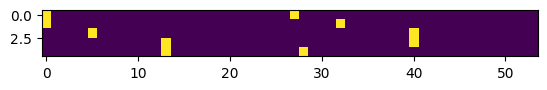

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x_enc[:5].view(5, -1))

In [31]:
# manual_generator = torch.Generator().manual_seed(2147483647)
# weights = torch.randn((54, 27), generator=manual_generator, requires_grad=True)
# logits = x_enc.view(x_enc.shape[0], -1) @ weights
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(x_enc.shape[0]), Y].log().mean() + 0.01*(weights**2).mean()
# weights.grad = None
# loss.backward()
# weights.data -= 0.1 * weights.grad
# loss

In [32]:
g = torch.Generator().manual_seed(2147483647)
weights = torch.randn((54, 27), generator=g, requires_grad = True)

In [33]:
steps = []
loss_per_step = []
for n in range(1000):
    # forward pass
    logits = x_enc.view(x_enc.shape[0], -1) @ weights
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(x_enc.shape[0]), Y].log().mean() + 0.01*(weights**2).mean()

    # backward pass
    weights.grad = None
    loss.backward()
    weights.data -= 32 * weights.grad
    # print(n)
    print(n, loss.item())
        

    steps.append(n)
    loss_per_step.append(loss.log10().item())

print(loss)


0 4.242240905761719
1 3.633540630340576
2 3.3356006145477295
3 3.1488282680511475
4 3.027508020401001
5 2.938632011413574
6 2.8744165897369385
7 2.823544502258301
8 2.783082962036133
9 2.748852491378784
10 2.7196786403656006
11 2.694190502166748
12 2.671778678894043
13 2.6518540382385254
14 2.6340482234954834
15 2.618039846420288
16 2.603590250015259
17 2.5904970169067383
18 2.578594446182251
19 2.5677406787872314
20 2.5578136444091797
21 2.5487077236175537
22 2.540329694747925
23 2.5325987339019775
24 2.5254433155059814
25 2.518800973892212
26 2.512617826461792
27 2.5068459510803223
28 2.5014448165893555
29 2.496378183364868
30 2.491614580154419
31 2.4871275424957275
32 2.4828920364379883
33 2.4788877964019775
34 2.475095510482788
35 2.47149920463562
36 2.468083620071411
37 2.4648354053497314
38 2.461742877960205
39 2.458794593811035
40 2.455981492996216
41 2.453294277191162
42 2.4507253170013428
43 2.4482662677764893
44 2.445911407470703
45 2.4436533451080322
46 2.4414868354797363
47

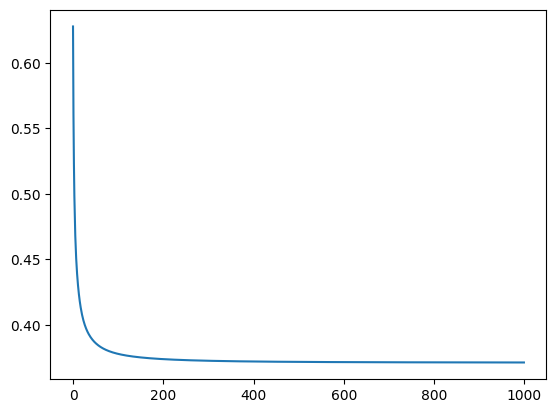

In [ ]:
plt.plot(steps, loss_per_step)

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    ix1 = 0
    index2 = 0
    out = []
    while True:
        x_enc = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float()
        logits = x_enc.view(-1, 54) @ weights
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)
        ix1 = ix2
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix2])
        if ix2 == 0:
            break
    print(''.join(out))

mor.
ays.
minaymnnyaes.
konamaloe.
caonawiqxarie.


#### E02
##### Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [59]:
def build_dataset(words, block_size):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for character in word + '.':
            index = stoi[character]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [85]:
# datasets
import random
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

bi_X_train, bi_Y_train = build_dataset(words[:n1], 1)
bi_X_dev, bi_Y_dev = build_dataset(words[n1:n2], 1)
bi_X_test, bi_Y_test = build_dataset(words[n2:], 1)

tri_X_train, tri_Y_train = build_dataset(words[:n1], 2)
tri_X_dev, tri_Y_dev = build_dataset(words[n1:n2], 2)
tri_X_test, tri_Y_test = build_dataset(words[n2:], 2)

In [90]:
# weights
g = torch.Generator().manual_seed(2147483647)
bi_weights = torch.randn((27, 27), generator=g, requires_grad = True)
tri_weights = torch.randn((54, 27), generator=g, requires_grad = True)
bi_x_enc = F.one_hot(bi_X_train, num_classes=27).float()
tri_x_enc = F.one_hot(tri_X_train, num_classes = 27).float()

In [104]:
steps = []
bi_train_loss_graph = []
tri_train_loss_graph = []
for n in range(1000):
    # bigram
    # forward pass
    bi_logits = bi_x_enc.view(bi_x_enc.shape[0], -1) @ bi_weights
    bi_counts = bi_logits.exp()
    bi_probs = bi_counts / bi_counts.sum(1, keepdims=True) 
    bi_train_loss = -bi_probs[torch.arange(bi_x_enc.shape[0]), bi_Y_train].log().mean() + 0.01*(bi_weights**2).mean()
 
    # backward pass
    bi_weights.grad = None
    bi_train_loss.backward()
    bi_weights.data += -32 * bi_weights.grad


    # trigram
    # forward pass
    tri_logits = tri_x_enc.view(tri_x_enc.shape[0], -1) @ tri_weights
    tri_counts = tri_logits.exp()
    tri_probs = tri_counts / tri_counts.sum(1, keepdim=True)
    tri_train_loss = -tri_probs[torch.arange(tri_x_enc.shape[0]), tri_Y_train].log().mean() + 0.01*(tri_weights**2).mean()

    # backward pass
    tri_weights.grad = None
    tri_train_loss.backward()
    tri_weights.data -= 32 * tri_weights.grad

    steps.append(n)
    bi_train_loss_graph.append(bi_train_loss.log10().item())
    tri_train_loss_graph.append(tri_train_loss.log10().item())

    print(n, " bi: ", bi_train_loss.item(), " tri: ", tri_train_loss.item())

0  bi:  2.4812562465667725  tri:  2.3522396087646484
1  bi:  2.481255531311035  tri:  2.3522379398345947
2  bi:  2.481255054473877  tri:  2.352236270904541
3  bi:  2.4812545776367188  tri:  2.3522348403930664
4  bi:  2.4812541007995605  tri:  2.3522331714630127
5  bi:  2.4812536239624023  tri:  2.352231740951538
6  bi:  2.4812533855438232  tri:  2.3522298336029053
7  bi:  2.481252908706665  tri:  2.3522284030914307
8  bi:  2.481252431869507  tri:  2.352226495742798
9  bi:  2.4812519550323486  tri:  2.3522253036499023
10  bi:  2.4812512397766113  tri:  2.3522236347198486
11  bi:  2.481250762939453  tri:  2.352222204208374
12  bi:  2.481250524520874  tri:  2.3522205352783203
13  bi:  2.481250047683716  tri:  2.3522188663482666
14  bi:  2.4812498092651367  tri:  2.352217197418213
15  bi:  2.4812490940093994  tri:  2.352215528488159
16  bi:  2.481248617172241  tri:  2.3522140979766846
17  bi:  2.481247901916504  tri:  2.35221266746521
18  bi:  2.481247901916504  tri:  2.3522112369537354
19

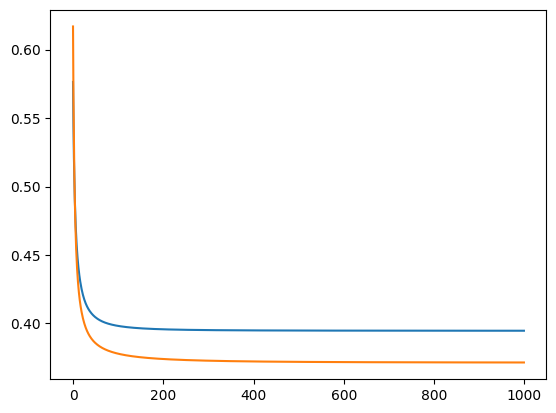

In [92]:
plt.plot(steps, bi_train_loss_graph, tri_train_loss_graph)

In [102]:
# loss on dev set
# bigram
bi_x_enc_dev = F.one_hot(bi_X_dev, num_classes=27).float()
bi_logits_dev = bi_x_enc_dev.view(bi_x_enc_dev.shape[0], -1) @ bi_weights
bi_counts_dev = bi_logits_dev.exp()
bi_probs_dev = bi_counts_dev / bi_counts_dev.sum(1, keepdims=True) 
bi_dev_loss = -bi_probs_dev[torch.arange(bi_x_enc_dev.shape[0]), bi_Y_dev].log().mean()

# trigram
tri_x_enc_dev = F.one_hot(tri_X_dev, num_classes=27).float()
tri_logits_dev = tri_x_enc_dev.view(tri_x_enc_dev.shape[0], -1) @ tri_weights
tri_counts_dev = tri_logits_dev.exp()
tri_probs_dev = tri_counts_dev / tri_counts_dev.sum(1, keepdim=True)
tri_dev_loss = -tri_probs_dev[torch.arange(tri_x_enc_dev.shape[0]), tri_Y_dev].log().mean()

print(" bi: ", bi_dev_loss.item(), " tri: ", tri_dev_loss.item())

 bi:  2.4668359756469727  tri:  2.3504345417022705


In [103]:
# loss on test set
# bigram
bi_x_enc_test = F.one_hot(bi_X_test, num_classes=27).float()
bi_logits_test = bi_x_enc_test.view(bi_x_enc_test.shape[0], -1) @ bi_weights
bi_counts_test = bi_logits_test.exp()
bi_probs_test = bi_counts_test / bi_counts_test.sum(1, keepdims=True) 
bi_test_loss = -bi_probs_test[torch.arange(bi_x_enc_test.shape[0]), bi_Y_test].log().mean()

# trigram
tri_x_enc_test = F.one_hot(tri_X_test, num_classes=27).float()
tri_logits_test = tri_x_enc_test.view(tri_x_enc_test.shape[0], -1) @ tri_weights
tri_counts_test = tri_logits_test.exp()
tri_probs_test = tri_counts_test / tri_counts_test.sum(1, keepdim=True)
tri_test_loss = -tri_probs_test[torch.arange(tri_x_enc_test.shape[0]), tri_Y_test].log().mean()

print(" bi: ", bi_test_loss.item(), " tri: ", tri_test_loss.item())

 bi:  2.4517111778259277  tri:  2.3353147506713867


#### E03
##### Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [105]:
# dataset
import random
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train_reg, Y_train_reg = build_dataset(words[:n1], 2)
X_dev_reg, Y_dev_reg = build_dataset(words[n1:n2], 2)
X_test_reg, Y_test_reg = build_dataset(words[n2:], 2)

In [150]:
# weights
g = torch.Generator().manual_seed(2147483647)
weights_reg = torch.randn((54, 27), generator=g, requires_grad = True)
x_enc_reg = F.one_hot(X_train_reg, num_classes = 27).float()

# training
for n in range(1000):
    # forward pass
    logits_reg = x_enc_reg.view(x_enc_reg.shape[0], -1) @ weights_reg
    counts_reg = logits_reg.exp()
    probs_reg = counts_reg / counts_reg.sum(1, keepdim=True)
    train_loss_reg = -probs_reg[torch.arange(x_enc_reg.shape[0]), Y_train_reg].log().mean() #+ 1*(weights_reg**2).mean()

    # backward pass
    weights_reg.grad = None
    train_loss_reg.backward()
    weights_reg.data -= 32 * weights_reg.grad

    print(n, " loss: ", train_loss_reg.item())

0  loss:  4.23160457611084
1  loss:  3.623490810394287
2  loss:  3.325791597366333
3  loss:  3.139456033706665
4  loss:  3.0183002948760986
5  loss:  2.929687023162842
6  loss:  2.8655648231506348
7  loss:  2.8148880004882812
8  loss:  2.774543046951294
9  loss:  2.7404582500457764
10  loss:  2.711392879486084
11  loss:  2.6860101222991943
12  loss:  2.663684368133545
13  loss:  2.643836498260498
14  loss:  2.626093626022339
15  loss:  2.6101386547088623
16  loss:  2.595733404159546
17  loss:  2.5826759338378906
18  loss:  2.5708024501800537
19  loss:  2.559971570968628
20  loss:  2.550062894821167
21  loss:  2.540970802307129
22  loss:  2.5326035022735596
23  loss:  2.5248796939849854
24  loss:  2.5177292823791504
25  loss:  2.511089563369751
26  loss:  2.5049071311950684
27  loss:  2.499134063720703
28  loss:  2.493729829788208
29  loss:  2.4886584281921387
30  loss:  2.483889102935791
31  loss:  2.4793941974639893
32  loss:  2.4751498699188232
33  loss:  2.471134901046753
34  loss: 

In [148]:
# loss on dev set
x_enc_dev_reg = F.one_hot(X_dev_reg, num_classes=27).float()
logits_dev_reg = x_enc_dev_reg.view(x_enc_dev_reg.shape[0], -1) @ weights_reg
counts_dev_reg = logits_dev_reg.exp()
probs_dev_reg = counts_dev_reg / counts_dev_reg.sum(1, keepdims=True) 
dev_loss_reg = -probs_dev_reg[torch.arange(x_enc_dev_reg.shape[0]), Y_dev_reg].log().mean()
print(dev_loss_reg.item())

2.4976372718811035


reg = 0.000 &nbsp;&nbsp;&nbsp;&nbsp; train loss = 2.3374624252319336 &nbsp;&nbsp;&nbsp;&nbsp; dev loss = 2.351595163345337<br>
reg = 0.001 &nbsp;&nbsp;&nbsp;&nbsp; train loss = 2.3390371799468994 &nbsp;&nbsp;&nbsp;&nbsp; dev loss = 2.351685047149658<br>
reg = 0.010 &nbsp;&nbsp;&nbsp;&nbsp; train loss = 2.350895404815674 &nbsp;&nbsp;&nbsp;&nbsp; dev loss = 2.3530962467193604<br>
reg = 0.100 &nbsp;&nbsp;&nbsp;&nbsp; train loss = 2.4149327278137207 &nbsp;&nbsp;&nbsp;&nbsp; dev loss = 2.375028371810913<br>
reg = 1.000 &nbsp;&nbsp;&nbsp;&nbsp; train loss = 2.6321210861206055 &nbsp;&nbsp;&nbsp;&nbsp; dev loss = 2.4976372718811035<br>


In [151]:
# loss on train set with 0.0 reg
x_enc_test_reg = F.one_hot(X_test_reg, num_classes=27).float()
logits_test_reg = x_enc_test_reg.view(x_enc_test_reg.shape[0], -1) @ weights_reg
counts_test_reg = logits_test_reg.exp()
probs_test_reg = counts_test_reg / counts_test_reg.sum(1, keepdims=True) 
test_loss_reg = -probs_test_reg[torch.arange(x_enc_test_reg.shape[0]), Y_test_reg].log().mean()
print(test_loss_reg.item())

2.3420145511627197


reg = 0.0 &nbsp;&nbsp;&nbsp;&nbsp; test loss = 2.3420145511627197

#### E04
##### We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [208]:
# dataset
X, Y = build_dataset(words, 1)
X = X.flatten()

In [219]:
# initialize the 'network'
manual_generator = torch.Generator().manual_seed(2147483647)
weights = torch.randn((27, 27), generator=g, requires_grad=True)

In [220]:
for k in range(1000):
  
  # forward pass
  logits = weights[X]
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(X.shape[0]), Y].log().mean() + 0.01*(weights**2).mean() # we add the mean to smoothen the model
  print(k, loss.item())
  
  # backward pass
  weights.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  weights.data += -32 * weights.grad


0 3.84027361869812
1 3.567146062850952
2 3.3720877170562744
3 3.227407455444336
4 3.120290994644165
5 3.039020299911499
6 2.974210262298584
7 2.9209747314453125
8 2.87680983543396
9 2.8399410247802734
10 2.808910608291626
11 2.782522201538086
12 2.7598328590393066
13 2.740116596221924
14 2.722813367843628
15 2.7074897289276123
16 2.6938064098358154
17 2.6814963817596436
18 2.670347213745117
19 2.6601920127868652
20 2.650895595550537
21 2.64235258102417
22 2.634474992752075
23 2.6271917819976807
24 2.620443344116211
25 2.61417818069458
26 2.608351469039917
27 2.6029245853424072
28 2.5978612899780273
29 2.593130588531494
30 2.588703155517578
31 2.5845530033111572
32 2.580655574798584
33 2.5769901275634766
34 2.5735363960266113
35 2.570277690887451
36 2.567196846008301
37 2.5642809867858887
38 2.5615172386169434
39 2.5588936805725098
40 2.556400775909424
41 2.5540294647216797
42 2.5517711639404297
43 2.5496180057525635
44 2.5475645065307617
45 2.5456039905548096
46 2.5437304973602295
47 2

torch.Size([228146, 27])

#### E05
##### Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [221]:
# dataset
X, Y = build_dataset(words, 1)
X = X.flatten()

In [222]:
# initialize the 'network'
manual_generator = torch.Generator().manual_seed(2147483647)
weights = torch.randn((27, 27), generator=g, requires_grad=True)

In [223]:
for k in range(1000):
  
  # forward pass
  logits = weights[X]

  loss = F.cross_entropy(logits, Y) + 0.01*(weights**2).mean()
  print(k, loss.item())
  
  # backward pass
  weights.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  weights.data += -32 * weights.grad


0 3.7887089252471924
1 3.514310598373413
2 3.3198130130767822
3 3.1773931980133057
4 3.075788736343384
5 3.0020389556884766
6 2.944772481918335
7 2.89839243888855
8 2.860034942626953
9 2.8277535438537598
10 2.800147294998169
11 2.7762088775634766
12 2.755206823348999
13 2.736600399017334
14 2.719980478286743
15 2.7050349712371826
16 2.691516399383545
17 2.679232120513916
18 2.6680257320404053
19 2.657770872116089
20 2.6483633518218994
21 2.6397171020507812
22 2.6317567825317383
23 2.6244194507598877
24 2.6176466941833496
25 2.6113884449005127
26 2.605597734451294
27 2.6002323627471924
28 2.5952515602111816
29 2.590620994567871
30 2.586306095123291
31 2.5822784900665283
32 2.578510046005249
33 2.5749764442443848
34 2.5716569423675537
35 2.5685317516326904
36 2.5655834674835205
37 2.562798261642456
38 2.5601625442504883
39 2.557663679122925
40 2.5552921295166016
41 2.553037405014038
42 2.5508921146392822
43 2.5488481521606445
44 2.546898126602173
45 2.5450360774993896
46 2.54325652122497